<h2>HW #5</h2>
Matt Buchovecky
Astro 283

In [77]:
# import modules
import numpy as np
from matplotlib import pyplot
%matplotlib inline 
from scipy import optimize, stats, special


<h2> Problem 1 </h2>

$$p\left(x\mid \alpha,\beta\right) = \left\{
\begin{array}{ll} 
 \alpha^{-1}\exp{\left(-\frac{x+\beta}{\alpha}\right)I_0\left(\frac{2\sqrt{x\beta}}{\alpha}\right)} & \quad \quad x\geq 0 \\
0 & \quad \quad x<0 \\
\end{array}
\right.
$$

In [172]:
# define the pdf for the Rice distribution as a subclass of rv_continuous 
class Rice_dist(stats.rv_continuous):
    "Rice distribution class"
        
    def _pdf(self, x, alpha, beta):
        if x > 0:
            return (1/alpha)*np.exp((x+beta)/(-alpha))*special.iv(0, 2*np.sqrt(x*beta)/alpha)
        else:
            return 0
        

In [59]:
# create an instance of the Rice distribution and create a set of samples from that distribution 
rice_inst = Rice_dist(a=0.0, name='Rice name') # b=inf

alpha, beta = (7., 47.)
mean_x = alpha + beta 
variance_x = alpha**2 + 2*alpha*beta

rice_trials_array = rice_inst.rvs(alpha=alpha, beta=beta, size=500)


162.6114823390682

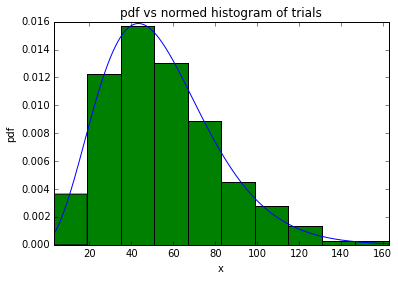

In [61]:
# compare the histogram of samples to the Rice curve

x = np.arange(rice_trials_array.min(), rice_trials_array.max(), 0.1)
p = pyplot.plot(x, rice_inst._pdf(x, alpha, beta))
h = pyplot.hist(rice_trials_array, normed=True)
pyplot.xlabel('x')
pyplot.ylabel('pdf')
pyplot.title("pdf vs normed histogram of trials")
pyplot.xlim(rice_trials_array.min(), rice_trials_array.max())
rice_trials_array.max()

In [18]:
# write the file, as the samples look good 
outfile = open("./buchovecky_matt_hw5_data.txt", 'w')
for trial in np.nditer(rice_trials_array):
    outfile.write(str(trial)+'\n')
outfile.close()

In [11]:
# compare expectation value and variance to that for Rie distribution 
print(mean_x)
print(rice_inst.expect(args=(alpha,beta)))
print(variance_x)
print(rice_inst.var(alpha=alpha, beta=beta))


60.0
59.99999999999999
1100.0
1100.00000004


<h2> Problem 2 </h2>
<h3> Comparing fit of second and third order polynomial models </h3>

We wish to find if these data are better fit by a second or third order polynomial model. We use Monte Carlo integration to estimate the ratio

\begin{eqnarray}
\frac{P\left(M_2\mid\{X_k,Y_k,\sigma_k\}\right)}{P\left(M_3\mid\{X_k,Y_k,\sigma_k\}\right)} &=& \frac{\int p\left(M_2,\vec{a}\mid\{X_k,Y_k,\sigma_k\}\right)d\vec{a}}{\int p\left(M_3,\vec{b}\mid\{X_k,Y_k,\sigma_k\}\right) d\vec{b}}\\
&=& \frac{\int P\left(\{X_k,Y_k,\sigma_k\}\mid M_2,\vec{a}\right)p\left(M_2,\vec{a}\right) d\vec{a}}{\int P\left(\{X_k,Y_k,\sigma_k\}\mid M_3,\vec{b}\right)p\left(M_3,\vec{b}\right) d\vec{b}} \\
\end{eqnarray}

the first line marginalizes the probability, then the second line applies Baye's theorem, where the probability of the data $P\left(\{X_k,Y_k,\sigma_k\}\right)$ is common to both and cancels. \\
If we assume the priors are uniform, they are equal to the inverse of the volume in phase space 

\begin{eqnarray}
\frac{p\left(M_2,\vec{a}\right)}{p\left(M_3,\vec{b}\right)} &=& \frac{\prod_{i=1}^3\frac{1}{a_i^\text{max}-a_i^\text{min}}}{\prod_{i=1}^4\frac{1}{b_i^\text{max}-b_i^\text{min}}}
\end{eqnarray}

The likelihood functions are those for independent and Gaussian distributed errors 

\begin{eqnarray}
P\left(\{X_k,Y_k,\sigma_k\}\mid M_n,\vec{c}\right) &=& \prod_{i=1}^N\frac{1}{\sqrt{2\pi\sigma^2_i}}\exp\left[-\frac{(y_i-f_n(x_i,\vec{c}))^2}{2\sigma_i^2}\right]\\
&=& \left(\prod_{i=1}^N\frac{1}{\sqrt{2\pi\sigma^2_i}}\right)\exp\left(-\frac{\chi_0^2}{2}\right)\exp\left(-\frac{\chi^2-\chi_0^2}{2}\right)
\end{eqnarray}

where $\vec{c}$ is just a generalized set of parameters, $\vec{a}$ and $\vec{b}$, $n$ is the order of the polynomial model, and $N$ is the number of data points, and the $f$ functions are just the polynomial models: 
\begin{eqnarray}
f_2(x_i,\vec{a}) &=& a_2x^2_i+a_1x_i+a_0 \\
f_3(x_i,\vec{b}) &=& b_3x^3_i+b_2x^2_i+b_1x_i+b_0
\end{eqnarray}


In [93]:
# read in the data for part 2 

infile = open("./hw5-data.txt", 'r')
x_arr = [ ]
y_arr = [ ] 
sigma_arr = [ ] 

for line in iter(infile):
    line = line.split()
    try:
        float(line[0]) and float(line[1]) and float(line[2])
        x_arr.append(float(line[0]))
        y_arr.append(float(line[1]))
        sigma_arr.append(float(line[2]))
    except ValueError:
        continue
    
infile.close()

print(x_arr)
print(y_arr)
print(sigma_arr)

[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
[3.46, 3.59, 4.19, 4.82, 7.02, 6.3, 6.11, 5.76, 8.47, 10.89]
[0.99, 1.0, 0.95, 0.74, 1.03, 1.07, 1.0, 0.99, 0.86, 0.61]


In [248]:
# define functions for the models, chi square, and marginal probability 

def poly_2nd_ord(x, a0, a1, a2):
    return a0 + a1*x + a2*x**2

def poly_3rd_ord(x, a0, a1, a2, a3):
    return a0 + a1*x + a2*x**2 + a3*pow(x,3)

# define a general 
def polynomial_gen(x, params):
    '''general polynomial function'''
    order = len(params) + 1
    sum = 0
    for i in range(0, order):
        sum = sum + params[i]*np.power(x, i)
    return sum
    
def chi_square(function, params, x_vals, data_vals, sig_vals):
    #check ndarray type 
    residuals = (data_vals - function(x_vals, *params))
    chis = (residuals**2)/np.power(sig_vals,2)
    chi_sum = np.sum(chis)
    d_o_f = len(x_vals) - len(params)
    #return (chi_sum, d_o_f)
    return chi_sum
    
def gauss_vec_cov(vals, vals_0, cov):
    if type(vals) is not np.matrix:
        vals = np.matrix(vals).T
    if type(vals_0) is not np.matrix:
        vals_0 = np.matrix(vals_0).T
    if type(cov) is not np.matrix:
        cov = np.matrix(cov)
    vec = np.matrix(vals - vals_0)
    return 1/((2*np.pi)*np.sqrt(np.linalg.det(cov)))*np.exp(-0.5*vec.T*cov.I*vec)


The gaussian function we sample from is centered around the best fit parameters, and is given by: 

\begin{eqnarray}
g_2\left(\vec{a},\vec{a}_0,\Sigma_2\right) &=& \frac{1}{\sqrt{(2\pi)^2\det\Sigma_2}}\exp\left[-\frac{1}{2}(\vec{a}-\vec{b}_0)^T\Sigma_2^{-1}(\vec{a}-\vec{a}_0)\right]\\
g_3\left(\vec{b},\vec{b}_0,\Sigma_3\right) &=& \frac{1}{\sqrt{(2\pi)^3\det\Sigma_3}}\exp\left[-\frac{1}{2}(\vec{b}-\vec{b}_0)^T\Sigma_3^{-1}(\vec{b}-\vec{b}_0)\right]
\end{eqnarray}

where $\Sigma$ represents the covariance matrix from the best fit 


In [113]:
# find the optimal fits for the models 

guess_2 = (1, 1, 1)
p_opt_2, p_cov_2 = optimize.curve_fit(poly_2nd_ord, x_arr, y_arr, guess_2, sigma_arr)

guess_3 = (1, 1, 1, 1)
p_opt_3, p_cov_3 = optimize.curve_fit(poly_3rd_ord, x_arr, y_arr, guess_3, sigma_arr)

for lst in [p_opt_2, p_cov_2, p_opt_3, p_cov_3]:
    print(lst)
    

[ 3.83018512 -0.10862277  0.07553306]
[[ 1.7791795  -0.65229982  0.04950895]
 [-0.65229982  0.28293943 -0.02305879]
 [ 0.04950895 -0.02305879  0.0019584 ]]
[ 1.01734443  2.301409   -0.43900777  0.03060818]
[[  3.23529256e+00  -2.16035481e+00   3.98285107e-01  -2.16270291e-02]
 [ -2.16035481e+00   1.65745100e+00  -3.27671089e-01   1.85299564e-02]
 [  3.98285107e-01  -3.27671089e-01   6.78784239e-02  -3.95613762e-03]
 [ -2.16270291e-02   1.85299564e-02  -3.95613762e-03   2.35336322e-04]]


The chi squared term tended to make the computation excessively large, too large for even 128-bit floats to handle. To 
make the numbers in the exponential smaller, we compare to the best fit parameters, rewriting: 

$$\prod_{i=1}^N\frac{1}{\sqrt{2\pi\sigma^2_i}}\exp\left[-\frac{(y_i-f_n(x_i,\vec{c}))^2}{2\sigma_i^2}\right]
= \left(\prod_{i=1}^N\frac{1}{\sqrt{2\pi\sigma^2_i}}\right)\exp\left(-\frac{\chi_0^2}{2}\right)\exp\left(-\frac{\chi^2-\chi_0^2}{2}\right)$$

where the chi squared terms can be written as: 

\begin{eqnarray}
\chi^2 &=& \sum_{i=1}^N\frac{(y_i-f_n(x_i,\vec{c}))^2}{\sigma_i^2}\\
\chi^2_0 &=& \sum_{i=1}^N\frac{(y_i-f_n(x_i,\vec{c}_0))^2}{\sigma_i^2}
\end{eqnarray}

and $A_0$ is the set of best fit parameters. For the fitting functions, we have


Plugging this all in, setting $a_i^\text{max}=b_i^\text{max}=4$, setting $a_i^\text{min}=b_i^\text{min}=-1$, and integrating $a_i,b_i$ from the max and min values, we get an estimate of the ratio written above.

The integration is done using a Monte Carlo rejection method. From the result, we see that the quadratic fit is better.


In [241]:
# Monte Carlo integration, uniform sampling 
def MC_int_uni_sampl(func, p_opt, p_cov, N, s=3.0):
    integral_sum = 0 
    V = np.prod([2*s*np.sqrt(p_cov[i][i]) for i in range(0, len(p_opt))])
    chisq_0 = chi_square(func, p_opt, x_arr, y_arr, sigma_arr)
    for n in range(0, N):
        param_rands = [ np.random.uniform(p_opt[i]-s*np.sqrt(p_cov[i][i]), p_opt[i]+s*np.sqrt(p_cov[i][i])) for i in range(0, len(p_opt)) ]
        chisq = chi_square(func, param_rands, x_arr, y_arr, sigma_arr)
        integral_sum += np.exp(-0.5*(chisq-chisq_0))
    return V * integral_sum / N


In [242]:
# Monte Carlo integration sampling from a gaussian 
def MC_int_gaus_sampl(func, p_opt, p_cov, N, s=3.0):
    n = 0 
    int_sum = 0 
    Mg = gauss_vec_cov(p_opt, p_opt, p_cov)
    chisq_0 = chi_square(func, p_opt, x_arr, y_arr, sigma_arr)
    while n < N:
        u_rand = np.random.rand()
        param_rands = [ np.random.uniform(p_opt[i]-s*np.sqrt(p_cov[i][i]), p_opt[i]+s*np.sqrt(p_cov[i][i])) for i in range(0, len(p_opt)) ]
        f_rej = gauss_vec_cov(param_rands, p_opt, p_cov)
        # f in rejection sampling -> g in mc integral
        if u_rand < f_rej/Mg:
            chisq = chi_square(func, param_rands, x_arr, y_arr, sigma_arr)
            int_sum += np.exp(-0.5*(chisq-chisq_0))/f_rej
            n += 1
    return int_sum / N

In [247]:
# compute ratio from uniform sampling 
mc_int_2 = MC_int_uni_sampl(poly_2nd_ord, p_opt_2, p_cov_2, 10000, s=3.0)
mc_int_3 = MC_int_uni_sampl(poly_3rd_ord, p_opt_3, p_cov_3, 10000, s=3.0)
chisq_2 = chi_square(poly_2nd_ord, p_opt_2, x_arr, y_arr, sigma_arr)
chisq_3 = chi_square(poly_3rd_ord, p_opt_3, x_arr, y_arr, sigma_arr)

ratio_uni = mc_int_3 / mc_int_2 * np.exp(-0.5*(chisq_3-chisq_2))
print(ratio_uni)

0.186439767834


In [ ]:
#  compute ratio from gaussian 
mc_int_2 = MC_int_gaus_sampl(poly_2nd_ord, p_opt_2, p_cov_2, 10000, s=1.0)
mc_int_3 = MC_int_gaus_sampl(poly_3rd_ord, p_opt_3, p_cov_3, 10000, s=1.0)
chisq_2 = chi_square(poly_2nd_ord, param_rands, x_arr, y_arr, sigma_arr)
chisq_3 = chi_square(poly_3rd_ord, param_rands, x_arr, y_arr, sigma_arr)

ratio_uni = mc_int_3 / mc_int_2 * np.exp(-0.5*(chisq_3-chisq_2))
print(ratio_uni)

It looks like 

$$
\frac{P\left(x^2\mid\{D\}\right)}{P\left(x^3\mid\{D\}\right)} \sim 10^5
$$

In [220]:
print(MC_int_uni_sampl(poly_2nd_ord, p_opt_2, p_cov_2, 10000, s=1.0))

0.00985264807174


In [237]:
print(MC_int_gaus_sampl(poly_2nd_ord, p_opt_2, p_cov_2, 10000, s=1.0))

[[ 0.00706148]]


In [238]:
print(MC_int_uni_sampl(poly_3rd_ord, p_opt_3, p_cov_3, 10000, s=1.0))

0.000274095870303


In [240]:
print(MC_int_gaus_sampl(poly_3rd_ord, p_opt_3, p_cov_3, 1000, s=1.0))

[[  9.26384378e-05]]


In [190]:
#print det of cov
print()

[[ 102.8429523]]


In [107]:
a1 = 2
a2 = 3 
a3 = 4

for num in [a1, a2, a3]:
    if num != 3:
        num = 3
        
print(num)
print(a1)
print(a2)
print(a3)

3
2
3
4


Compare fits

/Users/mbuchove/Programs/Anaconda3/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


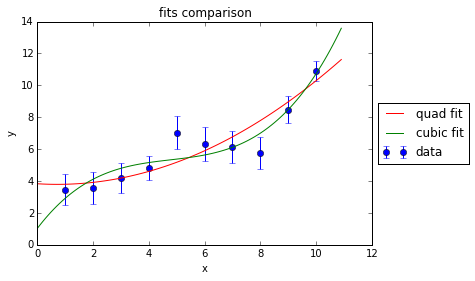

In [100]:
x_arr = np.asarray(x_arr)
x_range = np.arange(x_arr.min()-1., x_arr.max()+1., 0.1)
pyplot.errorbar(x_arr, y_arr, yerr=sigma_arr, fmt='bo', label='data')
pyplot.plot(x_range, poly_2nd_ord(x_range, *p_opt_2), 'r-', label='quad fit')
pyplot.plot(x_range, poly_3rd_ord(x_range, *p_opt_3), 'g-', label='cubic fit')
pyplot.ylabel('y')
pyplot.xlabel('x')
pyplot.title("fits comparison")
pyplot.legend(loc='center left', bbox_to_anchor=(1., 0.5))


In [ ]:
def rand_rejection(f, g_rand, a, b):
    u_rand = np.random.uniform(0, 1)
    M = 5.
    

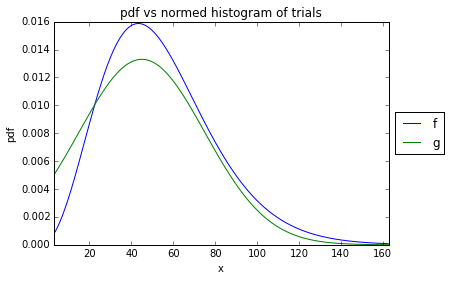

In [173]:
f = pyplot.plot(x, rice_inst._pdf(x, alpha, beta), label='f')
g = pyplot.plot(x, stats.norm.pdf(x, center, sigma), label='g')
pyplot.xlabel('x')
pyplot.ylabel('pdf')
pyplot.title("pdf vs normed histogram of trials")
pyplot.xlim(rice_trials_array.min(), rice_trials_array.max())
pyplot.legend(loc='center left', bbox_to_anchor=(1., 0.5))


In [ ]:
num_points = 1000
n = 0
guess = 45.
sigma = 30.
center = optimize.fmin(lambda x: -rice_inst._pdf(x,alpha,beta), guess)
M = optimize.fmin(lambda x: -rice_inst._pdf(x, alpha, beta)/stats.norm.pdf(x, center, sigma), center)
print(M)
while n < num_points:
    u_rand = np.random.uniform(0, 1)
    x_rand = np.random.normal(center, sigma)
    g_x = stats.norm.pdf(x_rand, center, sigma)
    n = n + 1
    

In [177]:
optimize.fmin?